In [34]:
import pandas as pd
import networkx as nx
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import os
import seaborn as sns

In [40]:
results_dir = '/shared/2/projects/cross-lingual-exchange/results/'
dfs = {}
dfs['betw'] = pd.read_csv(os.path.join(results_dir,'att_betweenness_11-02-2021.tsv'),sep='\t')
dfs['domain'] = pd.read_csv(os.path.join(results_dir,'att_domains_top100_with_rt_11-02-2021.tsv'),sep='\t')
dfs['hashtag'] = pd.read_csv(os.path.join(results_dir,'att_temporal_hashtags_top100_with_rt_11-02-2021.tsv'),sep='\t')
dfs['politics'] = pd.read_csv(os.path.join(results_dir,'politics_att_temporal_hashtag_top100_with_rt.tsv'),sep='\t')
dfs['entertainment'] = pd.read_csv(os.path.join(results_dir,'entertainment_att_temporal_hashtag_top100_with_rt.tsv'),sep='\t')
dfs['promotion'] = pd.read_csv(os.path.join(results_dir,'promotion_att_temporal_hashtag_top100_with_rt.tsv'),sep='\t')
dfs['sports'] = pd.read_csv(os.path.join(results_dir,'sports_att_temporal_hashtag_top100_with_rt.tsv'),sep='\t')



In [110]:
res = []
for key in dfs:
    df = dfs[key]
    df = df[df['Country']!='all']
    if key != 'betw':
        df = df[df['Estimate']>.0001]
        sig_pos = len(df[(df['Estimate']>1) & (df['Robust P-value']<0.05)])/len(df)
        sig_neg = len(df[(df['Estimate']<1) & (df['Robust P-value']<0.05)])/len(df)
        no_sig = 1 - sig_pos - sig_neg
        
    else:
        sig_pos = len(df[(df['Estimate']>0) & (df['Robust P-value']<0.05)])/len(df)
        sig_neg = len(df[(df['Estimate']<0) & (df['Robust P-value']<0.05)])/len(df)
        no_sig = 1 - sig_pos - sig_neg
    loci = len(df)
    mcp = len(set(df['Country Pair']))
    res.append([key,mcp,loci,sig_pos,sig_neg,no_sig])
overall_res = pd.DataFrame(res,columns=['Outcome','MCP','Loci','Sig Pos','Sig Neg','No Sig'])
overall_res.to_csv(os.path.join(results_dir,'overall_sig_counts_11-02-2021.tsv'),sep='\t')
overall_res

,Outcome,MCP,Loci,Sig Pos,Sig Neg,No Sig
0,betw,214,317,0.463722,0.022082,0.514196
1,domain,158,205,0.560976,0.034146,0.404878
2,hashtag,199,284,0.500000,0.035211,0.464789
3,politics,167,240,0.433333,0.054167,0.512500
4,entertainment,168,228,0.473684,0.035088,0.491228
5,promotion,115,146,0.369863,0.034247,0.595890
6,sports,146,199,0.432161,0.030151,0.537688


In [143]:
overall_res.transpose()

,0,1,2,3,4,5,6
Outcome,betw,domain,hashtag,politics,entertainment,promotion,sports
MCP,214,158,199,167,168,115,146
Loci,317,205,284,240,228,146,199
Sig Pos,0.463722,0.560976,0.5,0.433333,0.473684,0.369863,0.432161
Sig Neg,0.022082,0.034146,0.035211,0.054167,0.035088,0.034247,0.030151
No Sig,0.514196,0.404878,0.464789,0.5125,0.491228,0.59589,0.537688


In [521]:
df_combined = pd.concat(dfs)
df_combined[df_combined['Country']=='all']
#df_betw_overall = pd.read_csv(os.path.join(results_dir,'overall_att_betweenness.tsv'),sep='\t')

,,Country Pair,Country,Estimate,Std. Error,P-value,Outcome,Robust P-value,Robust Std. Error
domain,215,all,all,15.569893,0.003004,0.0,domain,0.0,0.003788
hashtag,292,all,all,3.975854,0.002033,0.0,hashtag,0.0,0.002218


In [108]:
df_combined = pd.concat(dfs)
df_combined[df_combined['Country']=='all']

,,Country Pair,Country,Estimate,Robust Std. Error,Robust P-value,Treated,Untreated,Std. Error,P-value,Treated_Outcome0,Treated_Outcome1,Untreated_Outcome0,Untreated_Outcome1
betw,317,all,all,0.034028,0.000483,0.0,1788344.0,165492069.0,NaN,NaN,NaN,NaN,NaN,NaN
domain,215,all,all,15.569893,0.003788,0.0,NaN,NaN,0.003004,0.0,3667500.0,152445.0,161415152.0,256972.0


In [56]:
for key in dfs:
    if key != 'betw':
        dfs[key] = dfs[key][dfs[key]['Estimate']>.0001]

In [5]:
dfs['betw']['Robust P-value'] = dfs['betw']['P-value']

In [57]:
pos = {}
pos['ES'] = (-4,39)
pos['PT'] = (-8,39)
pos['FR'] = (2,46)
pos['IT'] = (12.5,42)
pos['GR'] = (22,39)
pos['RO'] = (25,46)
#pos['BG'] = (25.5,43)
pos['RU'] = (37,57)
pos['FI'] = (26,62)
#pos['CZ'] = (15.5,50)
pos['DE'] = (10.5,51)
pos['TR'] = (33,39)
pos['SE'] = (14,60)
pos['NO'] = (9,62)
pos['PL'] = (19,52)
pos['HU'] = (19.5,47)
pos['LT'] = (24,55)
pos['EE'] = (25,58.5)
#pos['NL'] = (5.2,52)
pos['GB'] = (-2,53)


In [128]:
def create_graph(dfs,outcome):
    df = dfs[outcome]
    df = df[df['Country Pair']!='all']
    countries = list(df['Country'])
    country_pairs = list(df['Country Pair'])
    other = []
    for i,country_pair in enumerate(country_pairs):
        (c1,c2) = country_pair.split('_')
        if c1 == countries[i]:
            other.append(c2)
        else:
            other.append(c1)
    df['Country_Y'] = other
    df['Country_X'] = countries
    df = df[df['Robust P-value']<0.05]
    if outcome != 'betw':
        df = df[df['Estimate'] > 0.0001]
    DG = nx.DiGraph()
    DG.add_weighted_edges_from(df[['Country_Y','Country_X','Estimate']].values) #information from cy TO cx
    DG.remove_nodes_from(['AM','AZ','AT','LV','BY','IS','IE','IL','SI','DK','EE','CZ','BG','NL','LT'])
    return DG

In [116]:
other

NameError: name 'other' is not defined

In [91]:
def plot_network(DG,results_dir,outcome,title,betw=False):
    
    edges,weights = zip(*nx.get_edge_attributes(DG,'weight').items())
    colorscale = cm.get_cmap('coolwarm')
    widths = []
    colors = []

    if betw:
        for w in weights:
            if w < 0:
                colors.append(colorscale(0.85-(w/2)))
                widths.append(max(1,10*np.abs(w)))
            if w >= 0:
                colors.append(colorscale((max(weights)-2*w)/(2*max(weights))))
                widths.append(max(1,2*np.abs(w)))
    else:
        for w in weights:
            if w < 1:
                colors.append(colorscale(.99 + min(weights) -w))
                widths.append(min(3,2*np.abs(np.log(w))))
            if w >=1:
                0 to .5
                colors.append(colorscale(np.log(max(weights)/w)/(np.log(max(weights))*2)))
                widths.append(min(2.5,np.log(w)))

    options = {
        "node_color": "beige",
        'node_size': 100,
        "edge_color": colors,
        #"width": widths,
        "with_labels": True,
        "arrowstyle": '->',
        "arrowsize":20,
        "connectionstyle":'arc3, rad = 0.1'
    }

    nx.draw_spring(DG,**options)
    plt.title(title)
    plt.savefig(os.path.join(results_dir,outcome+'_network.pdf'))
    plt.show()

SyntaxError: invalid syntax (<ipython-input-91-8ab8c16f570c>, line 22)

In [122]:
def plot_map(DG,results_dir,outcome,title,betw=False):
    plt.figure(figsize=(9, 9))
    ax = plt.axes(projection=cartopy.crs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', alpha=1)
    ax.add_feature(cartopy.feature.OCEAN, facecolor='lightgrey')
    ax.set_extent ((-10, 40, 35, 65), cartopy.crs.PlateCarree())

    edges,weights = zip(*nx.get_edge_attributes(DG,'weight').items())
    colorscale = cm.get_cmap('coolwarm')
    widths = []
    colors = []

    if betw:
        for w in weights:
            if w < 0:
                colors.append(colorscale(0.85-(w/2)))
                widths.append(max(1,10*np.abs(w)))
            if w >= 0:
                colors.append(colorscale((max(weights)-2*w)/(2*max(weights))))
                widths.append(max(1,2*np.abs(w)))
    else:
        for w in weights:
            if w < 1:
                colors.append(colorscale(.99 + min(weights) -w))
                widths.append(min(3,2*np.abs(np.log(w))))
            if w >=1:
                #0 to .5
                colors.append(colorscale(np.log(max(weights)/w)/(np.log(max(weights))*2)))
                widths.append(min(2.5,np.log(w)))

    options = {
        "node_color": "beige",
        "edge_color": colors,
        "node_size":1000,
        "width": widths,
        "with_labels": True,
        "arrowstyle": '->',
        "arrowsize":20,
        "connectionstyle":'arc3, rad = 0.1'
    }

    nx.draw(DG, pos, **options)
    plt.title(title)
    plt.savefig(os.path.join(results_dir,outcome+'_map.pdf'))
    plt.show()

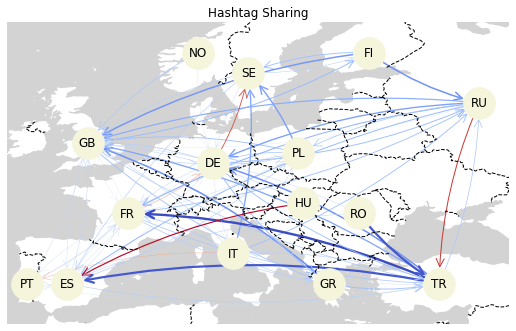

In [130]:
DG = create_graph(dfs,'hashtag')
plot_map(DG,results_dir,'hashtag','Hashtag Sharing',betw=False)

<ipython-input-128-330b6be37d6e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country_Y'] = other
<ipython-input-128-330b6be37d6e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country_X'] = countries


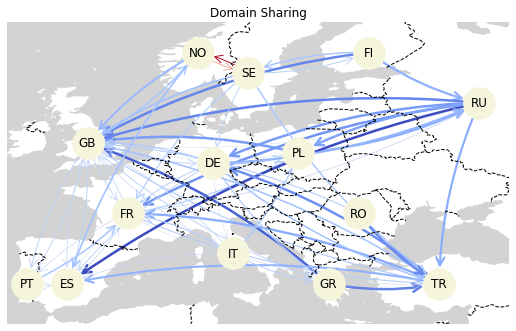

In [129]:
DG = create_graph(dfs,'domain')
plot_map(DG,results_dir,'domain','Domain Sharing',betw=False)

<ipython-input-128-330b6be37d6e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country_Y'] = other
<ipython-input-128-330b6be37d6e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country_X'] = countries


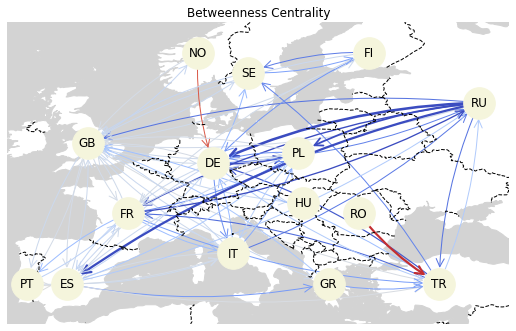

In [131]:
DG = create_graph(dfs,'betw')
plot_map(DG,results_dir,'betw','Betweenness Centrality',betw=True)

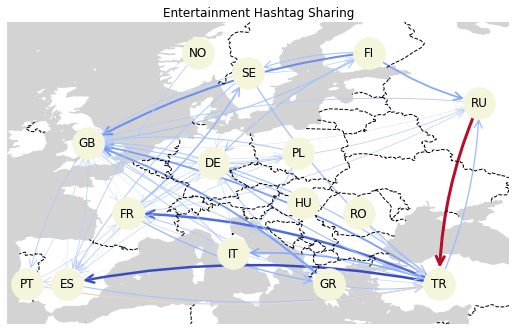

In [132]:
DG = create_graph(dfs,'entertainment')
plot_map(DG,results_dir,'entertainment','Entertainment Hashtag Sharing')

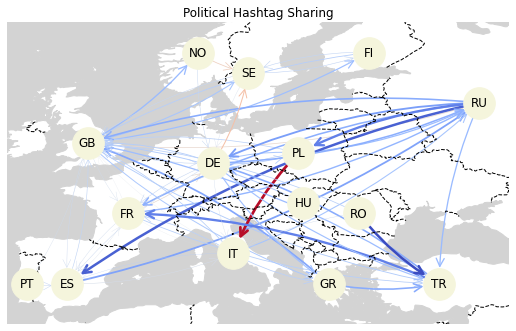

In [133]:
DG = create_graph(dfs,'politics')
plot_map(DG,results_dir,'politics','Political Hashtag Sharing')

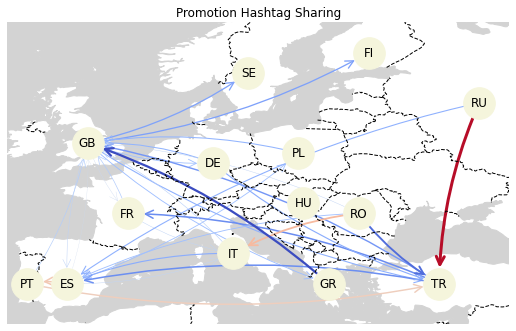

In [134]:
DG = create_graph(dfs,'promotion')
plot_map(DG,results_dir,'promotion','Promotion Hashtag Sharing')

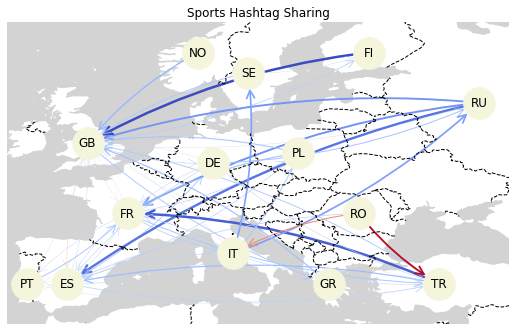

In [135]:
DG = create_graph(dfs,'sports')
plot_map(DG,results_dir,'sports','Sports Hashtag Sharing')

In [99]:
def create_full_graph(dfs,outcome,cutoff):
    df = dfs[outcome]
    df = df[df['Country Pair']!='all']
    countries = list(df['Country'])
    country_pairs = list(df['Country Pair'])
    other = []
    for i,country_pair in enumerate(country_pairs):
        (c1,c2) = country_pair.split('_')
        if c1 == countries[i]:
            other.append(c2)
        else:
            other.append(c1)
    df['Country_Y'] = other
    df['Country_X'] = df['Country']
    df = df[df['Robust P-value']<0.05]
    df = df[df['Estimate'] >= cutoff]
    if outcome != 'betw':
        df = df[df['Estimate'] > 0.0001]
    DG = nx.DiGraph()
    DG.add_weighted_edges_from(df[['Country_Y','Country_X','Estimate']].values) #information from cy TO cx
    return DG

In [100]:
#Pagerank: based on incoming links - high values mean multilingual have greater influence in taht country
#Country Metric Outcome Score
#DE Pagerank domain 0.06
results = []
for outcome in dfs.keys():
    if outcome == 'betw':
        DG = create_full_graph(dfs,outcome,cutoff=0)
    else:
        DG = create_full_graph(dfs,outcome,cutoff=1)
    print(DG.nodes())
    pagerank = nx.algorithms.link_analysis.pagerank_alg.pagerank(DG)
    hubs,authorities = nx.algorithms.link_analysis.hits_alg.hits(DG)
    for country in pagerank:
        results.append([country,'pagerank',outcome,pagerank[country]])
    for country in hubs:
        results.append([country,'hubs',outcome,hubs[country]])
    for country in authorities:
        results.append([country,'authorities',outcome,authorities[country]])
df_network = pd.DataFrame(results,columns=['Country','Measure','Outcome','Score'])
#df_network.to_csv(os.path.join(results_dir,'network_att_scores_sig.tsv'),sep='\t')
df_network

['GB', 'AM', 'IE', 'AT', 'IT', 'TR', 'BY', 'AZ', 'DE', 'NL', 'RU', 'BG', 'LV', 'CZ', 'DK', 'ES', 'FI', 'FR', 'PL', 'SE', 'NO', 'EE', 'GR', 'PT', 'HU', 'IL', 'IS', 'SI', 'RO', 'LT']
['AT', 'CZ', 'ES', 'FR', 'GB', 'GR', 'IE', 'NL', 'PL', 'RU', 'TR', 'AZ', 'DE', 'BG', 'BY', 'IT', 'SE', 'DK', 'EE', 'NO', 'PT', 'FI', 'IL', 'IS', 'RO', 'LT', 'LV']
['AT', 'CZ', 'ES', 'FR', 'GB', 'GR', 'IE', 'IT', 'PL', 'RU', 'TR', 'AZ', 'DE', 'NL', 'BG', 'BY', 'LV', 'NO', 'SE', 'DK', 'EE', 'FI', 'PT', 'RO', 'IL', 'HU', 'IS', 'SI']
['AT', 'CZ', 'ES', 'FR', 'GB', 'GR', 'IT', 'PL', 'RU', 'TR', 'AZ', 'DE', 'NL', 'BY', 'IE', 'NO', 'SE', 'DK', 'PT', 'FI', 'IL', 'HU', 'LV', 'RO', 'SI']
['AT', 'ES', 'FR', 'GB', 'IE', 'PL', 'RU', 'TR', 'AZ', 'DE', 'IT', 'BG', 'BY', 'CZ', 'FI', 'GR', 'NL', 'SE', 'DK', 'EE', 'IS', 'NO', 'PT', 'IL', 'HU', 'SI', 'LV']
['AT', 'ES', 'GB', 'NL', 'TR', 'AZ', 'FR', 'BY', 'CZ', 'IE', 'DE', 'EE', 'IT', 'SE', 'PL', 'RO', 'RU', 'FI', 'GR', 'PT', 'SI', 'HU']
['AT', 'ES', 'FR', 'GB', 'IE', 'NL', 'RU

<ipython-input-99-5b6e08945d09>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country_Y'] = other
<ipython-input-99-5b6e08945d09>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country_X'] = df['Country']


,Country,Measure,Outcome,Score
0,GB,pagerank,betw,0.111595
1,AM,pagerank,betw,0.022903
2,IE,pagerank,betw,0.102771
3,AT,pagerank,betw,0.023932
4,IT,pagerank,betw,0.062564
...,...,...,...,...
550,IS,authorities,sports,0.000000
551,LT,authorities,sports,0.000000
552,LV,authorities,sports,0.000000
553,NO,authorities,sports,0.000000


In [517]:
df_network = pd.DataFrame(results,columns=['Country','Measure','Outcome','Score'])

In [101]:
df_network
for outcome in dfs:
    for measure in ['pagerank','hubs','authorities']:
        df_sub = df_network[(df_network['Outcome']==outcome)]
        df_sub = df_sub[df_sub['Measure']==measure]
        df_sub = df_sub.sort_values(by='Score',ascending=False)[:5]
        print(df_sub)

   Country   Measure Outcome     Score
0       GB  pagerank    betw  0.111595
2       IE  pagerank    betw  0.102771
8       DE  pagerank    betw  0.086930
4       IT  pagerank    betw  0.062564
18      PL  pagerank    betw  0.059445
   Country Measure Outcome     Score
40      RU    hubs    betw  0.297328
36      BY    hubs    betw  0.143102
35      TR    hubs    betw  0.099667
38      DE    hubs    betw  0.056141
34      IT    hubs    betw  0.053737
   Country      Measure Outcome     Score
62      IE  authorities    betw  0.177941
68      DE  authorities    betw  0.166766
78      PL  authorities    betw  0.096089
75      ES  authorities    betw  0.094802
77      FR  authorities    betw  0.073987
    Country   Measure Outcome     Score
94       GB  pagerank  domain  0.217344
93       FR  pagerank  domain  0.117723
92       ES  pagerank  domain  0.099946
100      TR  pagerank  domain  0.087803
99       RU  pagerank  domain  0.069170
    Country Measure Outcome     Score
126      RU   

In [410]:
dfs['betw'][dfs['betw']['Country Pair']=='ES_PT']

,Country Pair,Country,Estimate,Std. Error,P-value,Outcome,Robust P-value
184,ES_PT,ES,0.009445,0.003196,0.003123,betw,0.003123
185,ES_PT,PT,-0.008050,0.003593,0.025055,betw,0.025055


In [368]:
np.log(0.2708187388823047)

-1.30630554210212

In [632]:
df_network[(df_network['Outcome']=='domain') & 
           (df_network['Measure']=='authorities')] \
.sort_values(by='Score',ascending=False)

,Country,Measure,Outcome,Score
140,ES,authorities,domain,0.353378
141,FR,authorities,domain,0.259250
142,GB,authorities,domain,0.186816
150,DE,authorities,domain,0.077587
148,TR,authorities,domain,0.063303
146,PL,authorities,domain,0.042427
147,RU,authorities,domain,0.006940
143,GR,authorities,domain,0.002136
145,NL,authorities,domain,0.002002
144,IE,authorities,domain,0.001161


In [597]:
dfs['betw']['Robust Std. Error'] = dfs['betw']['Std. Error']
dfs['betw']['Robust P-value'] = dfs['betw']['P-value']

In [606]:
def sig(df,colname):
    if (df[colname] <= .001):
        return '***'
    elif (df[colname] <= .01):
        return '**'
    elif (df[colname] <= .05):
        return '*'
    else:
        return 'n.s.'

In [607]:
def annotate(data, **kws):
    bar_pos = [0,1]
    plt.errorbar(x=bar_pos,y=data['Estimate'],yerr=1.96*data['Robust Std. Error'],ecolor='black',ls='none',lw=.5)
    #plt.axhline(1,color='black',linewidth=1)
    stars = list(data['sig'])
    for i,_ in enumerate(stars):
        plt.text(i+.05,max(0,1.01*list(data['Estimate'])[i]),stars[i])
        plt.text(i-.3,max(0,1.01*list(data['Estimate'])[i]),round(list(data['Estimate'])[i],3))

In [608]:
def plot_effect(df_sub,no_effect_line,title,xticklabels,out_file):
    df_sub['ci'] = [i*1.96 for i in df_sub['Robust Std. Error']]
    df_sub['sig'] = df_sub.apply(sig,colname='Robust P-value', axis = 1)
    g = sns.FacetGrid(df_sub, col="Country Pair",sharex=False,sharey=True,margin_titles=False,height=2, aspect=1.5)
    g.map_dataframe(sns.barplot, x="Country", y="Estimate",palette=sns.color_palette('colorblind')[2::-1])
    g.map_dataframe(annotate)
    g.set_axis_labels("Country","Estimate")
    ax1 = g.axes.flat[0]
    ax2 = g.axes.flat[1]
    ax3 = g.axes.flat[2]
    ax1.set_xticklabels(xticklabels[0],size=10,rotation=5)
    ax2.set_xticklabels(xticklabels[1],size=10,rotation=5)
    ax3.set_xticklabels(xticklabels[2],size=10,rotation=5)
    g.set_titles('')
    g.set_xlabels('')
    g.fig.suptitle(title, y=1.05)
    #People who tweet in non-dominant language have higher betweenness centrality
    #plt.savefig('multilingual_friend_hashtag_binary_plot.pdf',bbox_inches='tight')
    plt.show()

<ipython-input-608-6e9b6db0fb2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['ci'] = [i*1.96 for i in df_sub['Robust Std. Error']]
<ipython-input-608-6e9b6db0fb2d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['sig'] = df_sub.apply(sig,colname='Robust P-value', axis = 1)


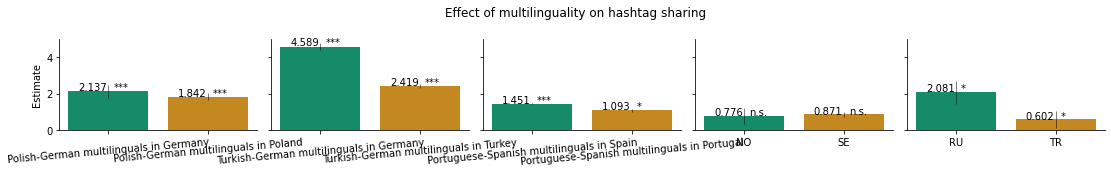

In [620]:

country_pairs = ['DE_PL','DE_TR','ES_PT','NO_SE','RU_TR']
out_dir = os.path.join(results_dir,'plots')
#for outcome in ['betw','hashtag','politics','entertainment']:
df_sub = dfs['hashtag'][dfs['hashtag']['Country Pair'].isin(country_pairs)]
out_file = os.path.join(out_dir,outcome +'_3pairs.pdf')
label0 = ['Polish-German multilinguals in Germany','Polish-German multilinguals in Poland']
label1 = ['Turkish-German multilinguals in Germany','Turkish-German multilinguals in Turkey']
label2 = ['Portuguese-Spanish multilinguals in Spain','Portuguese-Spanish multilinguals in Portugal']
xticklabels = [label0,label1,label2]
title = 'Effect of multilinguality on hashtag sharing'
ylabel = 'Odds ratio'
plot_effect(df_sub,0,title,xticklabels,out_file)


In [621]:
dfs['hashtag'][dfs['hashtag']['Country Pair'].isin(country_pairs)]

,Country Pair,Country,Estimate,Std. Error,P-value,Robust Std. Error,Robust P-value
72,DE_PL,DE,2.137367,0.170810,8.718946e-06,0.178422,2.070210e-05
73,DE_PL,PL,1.842063,0.080103,2.444289e-14,0.096537,2.483107e-10
80,DE_TR,DE,4.588922,0.069943,5.157505e-105,0.093944,3.723113e-59
81,DE_TR,TR,2.419483,0.042124,1.157573e-97,0.048310,1.006707e-74
125,ES_PT,ES,1.451451,0.012851,1.076901e-184,0.016217,8.582135e-117
126,ES_PT,PT,1.093456,0.031426,4.469932e-03,0.043705,4.092868e-02
271,NO_SE,NO,0.775758,0.149298,8.904305e-02,0.221649,2.519736e-01
272,NO_SE,SE,0.870894,0.058466,1.806512e-02,0.079431,8.180223e-02
288,RU_TR,RU,2.080817,0.343262,3.278625e-02,0.331505,2.707697e-02
289,RU_TR,TR,0.602413,0.243213,3.717670e-02,0.231929,2.887407e-02


In [619]:
dfs['hashtag'][(dfs['hashtag']['Estimate']<1) & ()]

,Country Pair,Country,Estimate,Std. Error,P-value,Robust Std. Error,Robust P-value
2,AT_FI,FI,0.471245,0.253280,0.002977,0.300369,0.012251
3,AT_FR,AT,0.946309,0.154800,0.721481,0.287791,0.847933
14,AT_SE,SE,0.670371,0.150896,0.008045,0.172543,0.020459
23,AZ_PL,PL,0.638425,1.018852,0.659614,1.039053,0.665825
24,AZ_PT,PT,0.000010,248.721900,0.963157,0.164372,0.000000
...,...,...,...,...,...,...,...
281,PL_TR,PL,0.637908,1.019898,0.659366,1.038946,0.665226
282,PL_TR,TR,0.652373,0.563195,0.448199,0.584989,0.465289
285,PT_TR,PT,0.000010,248.978342,0.963177,0.165920,0.000000
289,RU_TR,TR,0.602413,0.243213,0.037177,0.231929,0.028874


In [631]:
dfs['domain'].sort_values(by='Estimate',ascending=False)

,Country Pair,Country,Estimate,Std. Error,P-value,Robust Std. Error,Robust P-value
116,FR_IL,FR,106.562018,0.292227,1.905496e-57,0.303653,2.401118e-53
24,BY_ES,ES,76.729892,0.239240,1.531629e-73,0.300669,3.096080e-47
100,ES_RU,ES,75.359810,0.232981,8.123877e-77,0.295235,1.558471e-48
132,GB_GR,GB,47.055796,0.601332,1.507231e-10,0.381974,6.587364e-24
27,BY_GB,GB,30.628065,0.126039,2.707550e-162,0.189496,6.827640e-73
...,...,...,...,...,...,...,...
212,RU_TR,RU,0.000011,114.487855,9.205879e-01,0.152521,0.000000e+00
196,LT_NL,NL,0.000009,359.344635,9.741143e-01,0.291870,0.000000e+00
82,EE_PT,PT,0.000005,294.765563,9.670618e-01,0.475206,1.064607e-144
117,FR_IS,FR,0.000004,984.523546,9.899912e-01,0.197323,0.000000e+00


In [640]:
dfs['domain'][dfs['domain']['Country']=='DE'].sort_values(by='Estimate',ascending=False)

,Country Pair,Country,Estimate,Std. Error,P-value,Robust Std. Error,Robust P-value
16,AZ_DE,DE,20.014474,0.132501,5.269349e-113,0.251978,1.306735e-32
64,DE_TR,DE,18.785483,0.130130,2.847542e-112,0.263578,9.170601e-29
60,DE_RU,DE,14.065982,0.291826,1.330307e-19,0.362650,3.097081e-13
23,BY_DE,DE,12.146257,0.333343,6.887394e-14,0.400341,4.453824e-10
50,DE_IE,DE,2.499351,0.037192,1.276691e-133,0.185276,7.648260e-07
46,DE_GB,DE,2.442875,0.036901,3.948613e-129,0.196804,5.667944e-06
62,DE_SE,DE,2.408063,0.233939,1.722910e-04,0.285136,2.055348e-03
52,DE_IT,DE,1.679698,0.239421,3.030380e-02,0.280464,6.443933e-02
41,DE_ES,DE,1.415459,0.449045,4.390739e-01,0.477063,4.664194e-01
55,DE_NL,DE,1.413799,0.228067,1.289336e-01,0.260465,1.836924e-01


In [136]:
dfs['domain']

,Country Pair,Country,Estimate,Std. Error,P-value,Robust Std. Error,Robust P-value,Treated_Outcome0,Treated_Outcome1,Untreated_Outcome0,Untreated_Outcome1
0,AM_RU,RU,1.738544,0.326154,8.994998e-02,0.336092,9.986111e-02,115,12,310934,3286
1,AT_CZ,CZ,1.870726,0.249113,1.194137e-02,0.291363,3.158360e-02,216,21,12709,164
2,AT_ES,ES,2.248773,0.155382,1.834125e-07,0.178841,5.861521e-06,2788,43,877970,1669
3,AT_FI,FI,0.320044,0.444570,1.039389e-02,0.498075,2.217232e-02,287,6,18751,172
4,AT_FR,FR,2.774888,0.127489,1.191763e-15,0.147661,4.784505e-12,4541,81,805011,1243
...,...,...,...,...,...,...,...,...,...,...,...
210,PT_TR,TR,2.010376,0.564163,2.157898e-01,0.532830,1.899963e-01,3911,4,1153154,211
211,RO_TR,TR,20.155492,0.065744,0.000000e+00,0.081893,1.795966e-294,4420,284,1150645,1918
213,RU_TR,TR,9.040787,0.410046,7.896611e-08,0.412005,9.092976e-08,775,8,1156243,247
214,SE_TR,TR,4.139511,0.476083,2.846193e-03,0.573189,1.319821e-02,1855,6,1155257,158


In [137]:
152445 / (3667500+152445)

0.03990764264930516

In [138]:
foo = dfs['domain'][dfs['domain']['Country']!='all']

In [142]:
foo['Treated_Outcome1'].sum() / (foo['Treated_Outcome0'].sum()+foo['Treated_Outcome1'].sum())

0.040462127074542276